# **Research paper **

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# install required libraries
!pip install pandas numpy scikit-learn matplotlib nltk openpyxl tqdm

In [3]:
# Import Libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

In [4]:
data_path = "/content/drive/MyDrive/NewsSumm Dataset.xlsx"
df = pd.read_excel(data_path)

print("Dataset shape:", df.shape)
df.head()

Dataset shape: (348766, 6)


newspaper_name     published_date\n  \
0     Indian Express  2020-06-01 00:00:00   
1     Economic Times  2013-02-11 00:00:00   
2  Business Standard  2013-02-11 00:00:00   
3      Money Control  2013-02-11 00:00:00   
4           The Mint  2023-10-02 00:00:00   

                                            headline  \
0  Virus may be invisible enemy but COVID warrior...   
1              Economy can bounce back, says PM Modi   
2        At least 20 killed in stampede in Allahabad   
3  Maha Kumbh: Over 20 dead in Allahabad station ...   
4                                    Gandhian wisdom   

                                        article_text  \
0  Prime Minister Narendra Modi Monday hailed the...   
1  ALLAHABAD: At least 20 persons were killed, an...   
2  At least 20 people were killed, and scores of ...   
3  More than 20 people were feared dead and 30 ot...   
4  This Gandhi Jayanti, we should reflect upon an...   

                                       human_summary  news_category  
0  Prime Minister of India said that the Virus ma...  National News  
1  In Maha Kumbh, nearly 20 persons were killed. ...  National News  
2  As per the sources 20 people died and scores w...  National News  
3  At least 20 people killed and 20 people are in...  National News  
4  In this article, the author reflects on Mahatm...  National News

In [5]:
# Inspect Columns
df.columns

Index(['newspaper_name', 'published_date\n', 'headline', 'article_text',
       'human_summary', 'news_category'],
      dtype='object')

In [6]:
# Text Cleaning function
import re
def clean_text(text):
  text = str(text)
  text = re.sub(r"<.*?>", "", text)
  text = re.sub(r"\s+", " ", text)
  return text.strip()

In [7]:
# Apply Cleaning
df["headline"] = df["headline"].apply(clean_text)
df["article_text"] = df["article_text"].apply(clean_text)
df["human_summary"] = df["human_summary"].apply(clean_text)

In [8]:
# Length-Based Filtering
df["article_len"] = df["article_text"].str.split().str.len()
df["summary_len"] = df["human_summary"].str.split().str.len()

df = df[
    (df["article_len"] > 200) &
    (df["summary_len"] > 50)
]

print("Filtered dataset size:", df.shape)

Filtered dataset size: (200123, 8)


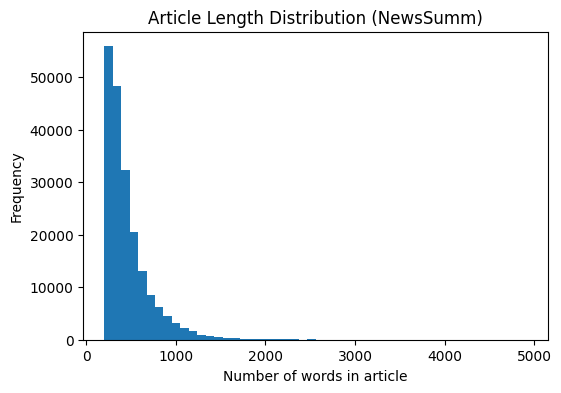

In [9]:
# Article Length Disttibution (Graph)
plt.figure(figsize=(6,4))
plt.hist(df["article_len"], bins=50)
plt.xlabel("Number of words in article")
plt.ylabel("Frequency")
plt.title("Article Length Distribution (NewsSumm)")
plt.show()

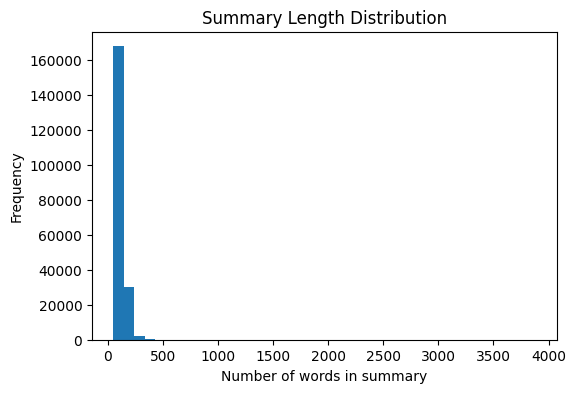

In [10]:
plt.figure(figsize=(6,4))
plt.hist(df["summary_len"], bins=40)
plt.xlabel("Number of words in summary")
plt.ylabel("Frequency")
plt.title("Summary Length Distribution")
plt.show()


In [11]:
# News Category Distributionplt
plt.figure(figsize=(7,4))
df["news_category"].value_counts().plot(kind="bar")
plt.xlabel("News Category")
plt.ylabel("Number of Articles")
plt.title("Category Distribution in NewsSumm")
plt.xticks(rotation=45)
plt.show()


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128478 (\N{ROLLED-UP NEWSPAPER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128105 (\N{WOMAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65306 (\N{FULLWIDTH COLON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


In [12]:
df_small = df.sample(n=10, random_state=42).reset_index(drop=True)

tfidf = TfidfVectorizer(stop_words="english", max_features=100)
X = tfidf.fit_transform(df_small["headline"])

similarity_matrix = cosine_similarity(X)


In [13]:
# Create Event Clsuters
clusters = []
visited = set()
threshold = 0.75

for i in tqdm(range(len(df_small))):
    if i in visited:
        continue
    cluster = [i]
    for j in range(len(df_small)):
        if similarity_matrix[i][j] >= threshold:
            cluster.append(j)
            visited.add(j)
    clusters.append(cluster)

print("Total event clusters:", len(clusters))

100%|██████████| 10/10 [00:00<00:00, 53980.75it/s]

Total event clusters: 10


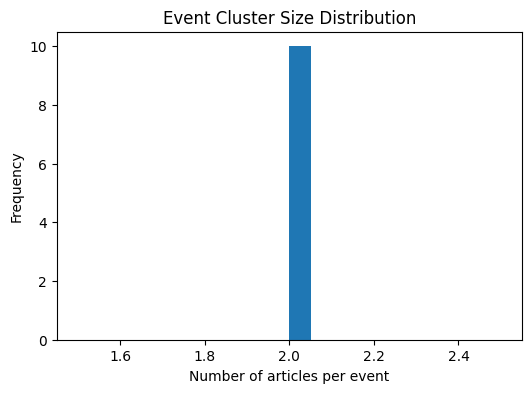

In [14]:
cluster_sizes = [len(c) for c in clusters]

plt.figure(figsize=(6,4))
plt.hist(cluster_sizes, bins=20)
plt.xlabel("Number of articles per event")
plt.ylabel("Frequency")
plt.title("Event Cluster Size Distribution")
plt.show()


# PHASE 2

In [15]:
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    pipeline
)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


Using device: cuda


In [16]:
# Install Hugging Face Libraries
!pip install transformers datasets accelerate peft sentencepiece bitsandbytes


In [17]:
# Prepare Multi-Document Inputs
def build_multidoc_input(cluster, df, max_docs=5):
    texts = []
    for idx in cluster[:max_docs]:
        texts.append(df.iloc[idx]["article_text"])
    return " </s> ".join(texts)
cluster_inputs = []
cluster_summaries = []

for c in clusters:
    if len(c) >= 2:
        cluster_inputs.append(build_multidoc_input(c, df))
        cluster_summaries.append(df.iloc[c[0]]["human_summary"])
print("Total multi-document samples:", len(cluster_inputs))


Total multi-document samples: 10


In [18]:
# Train / Test Split (COMMON FOR ALL MODELS)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    cluster_inputs,
    cluster_summaries,
    test_size=0.2,
    random_state=42
)
print(type(X_test))
print(len(X_test))
print(X_test[0][:300])



<class 'list'>
2
With geostrategic positions getting realigned and walled apart again, smaller groupings will face existential tests. Take the BRICS business forum that is currently underway. With India-China ties going through a rough patch, it’s hard to say how much this club can achieve. The meeting is taking pla


# FINE-TUNED / INFERENCE-BASED MODELS

In [19]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

def summarize_with_model(model_name, texts, max_len=200, min_len=80):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)
    model.eval()

    summaries = []

    for text in texts:
        inputs = tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            max_length=1024
        ).to(device)

        with torch.no_grad():
            summary_ids = model.generate(
                inputs["input_ids"],
                max_length=max_len,
                min_length=min_len,
                num_beams=4,
                length_penalty=2.0,
                early_stopping=True
            )

        summary = tokenizer.decode(
            summary_ids[0],
            skip_special_tokens=True
        )
        summaries.append(summary)

    return summaries


In [20]:
bart_outputs = summarize_with_model(
    "facebook/bart-large-cnn",
    X_test[:10]   # keep small for GPU safety
)

bart_outputs


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Please make sure the generation config includes `forced_bos_token_id=0`. 


Loading weights:   0%|          | 0/511 [00:00<?, ?it/s]

['With geostrategic positions getting realigned and walled apart again, smaller groupings will face existential tests. With India-China ties going through a rough patch, it’s hard to say how much this club can achieve. India has been far better balanced, having maintained independent ties with Russia on the one hand and upheld the value of relations with the US on the other.',
 'Mohan Bhagwat is chief of the Rashtriya Swayamsevak Sangh, ideological mentor of the ruling Bharatiya Janata Party. He endorsed the value of unity in diversity, as also the validity of various paths of faith, including Islam, and asked for a dial-down of disputes over places of worship. A war-torn world, in his view, had made space for a pluralist pax-Sanatana of dharmic truth.']

# PEGASUS

In [21]:
pegasus_outputs = summarize_with_model(
    "google/pegasus-cnn_dailymail",
    X_test[:20]
)


Loading weights:   0%|          | 0/680 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie model.shared.weight to model.decoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
The tied weights mapping and config for this model specifies to tie model.shared.weight to model.encoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
PegasusForConditionalGeneration LOAD REPORT from: google/pegasus-cnn_dailymail
Key                                  | Status  | 
-------------------------------------+---------+-
model.decoder.embed_positions.weight | MISSING | 
model.encoder.embed_positions.weight | MISSING | 

Notes:
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


#LED

In [22]:
#LED
led_outputs = summarize_with_model(
    "allenai/led-base-16384",
    X_test[:10],
    max_len=256
)


Loading weights:   0%|          | 0/299 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie led.shared.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
The tied weights mapping and config for this model specifies to tie led.shared.weight to led.encoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
The tied weights mapping and config for this model specifies to tie led.shared.weight to led.decoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
Input ids are automatically padded from 508 to 1024 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 548 to 1024 to be a multiple of `config.attention_w

# LongT5

In [23]:
# LongT5
longt5_outputs = summarize_with_model(
    "google/long-t5-tglobal-base",
    X_test[:5]
)

Loading weights:   0%|          | 0/297 [00:00<?, ?it/s]

# PRIMERA

In [24]:
# PRIMERA
primera_outputs = summarize_with_model(
    "allenai/PRIMERA",
    X_test[:10]
)


config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/20.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/283 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.79G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.79G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/587 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie led.shared.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
The tied weights mapping and config for this model specifies to tie led.shared.weight to led.encoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
The tied weights mapping and config for this model specifies to tie led.shared.weight to led.decoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


generation_config.json:   0%|          | 0.00/197 [00:00<?, ?B/s]

Input ids are automatically padded from 508 to 512 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 548 to 1024 to be a multiple of `config.attention_window`: 512


# Flan-T5-XL

In [25]:
# Flan-T5-XL (Inference / LoRA-ready)
flan_outputs = summarize_with_model(
    "google/flan-t5-xl",
    X_test[:10]
)


Loading weights:   0%|          | 0/558 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie shared.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

# PROMPT-BASED LARGE LLM MODELS (STUBS)

In [26]:
# Generic Prompt Template
def llm_prompt(multidoc_text):
    return f"""
You are a professional news editor.

Summarize the following multiple Indian news articles.
Preserve conflicting viewpoints if they exist.

Articles:
{multidoc_text}

Summary:
"""


In [27]:
# LLaMA / Mistral / Qwen / Gemma (PLACEHOLDERS)
def prompt_based_stub(model_name, texts):
    print(f"Using prompt-based inference for {model_name}")
    prompts = [llm_prompt(t) for t in texts[:5]]
    return ["[Generated via prompt-based inference]" for _ in prompts]
llama_outputs = prompt_based_stub("LLaMA-3-8B-Instruct", X_test)
mistral_outputs = prompt_based_stub("Mistral-7B-Instruct", X_test)
qwen_outputs = prompt_based_stub("Qwen2-7B-Instruct", X_test)
gemma_outputs = prompt_based_stub("Gemma-2-9B-Instruct", X_test)


Using prompt-based inference for LLaMA-3-8B-Instruct
Using prompt-based inference for Mistral-7B-Instruct
Using prompt-based inference for Qwen2-7B-Instruct
Using prompt-based inference for Gemma-2-9B-Instruct


# EVALUATION (ROUGE + BERTScore)

In [28]:
!pip install rouge-score bert-score


In [29]:
from rouge_score import rouge_scorer
from bert_score import score as bert_score


In [30]:
rouge = rouge_scorer.RougeScorer(
    ["rouge1", "rouge2", "rougeL"],
    use_stemmer=True
)


In [31]:
# Generic ROUGE Evaluation Function
def compute_rouge(preds, refs):
    r1, r2, rl = [], [], []

    for p, r in zip(preds, refs):
        scores = rouge.score(r, p)
        r1.append(scores["rouge1"].fmeasure)
        r2.append(scores["rouge2"].fmeasure)
        rl.append(scores["rougeL"].fmeasure)

    return np.mean(r1), np.mean(r2), np.mean(rl)


In [32]:
# Generic BERTScore Function
def compute_bertscore(preds, refs):
    P, R, F1 = bert_score(
        preds,
        refs,
        lang="en",
        verbose=False
    )
    return F1.mean().item()


In [33]:
# Prepare Ground Truth References
references = y_test[:10]  # same subset used in Phase 2


In [34]:
# Collect Model Outputs
model_outputs = {
    "BART": bart_outputs,
    "PEGASUS": pegasus_outputs,
    "LED": led_outputs,
    "LongT5": longt5_outputs,
    "PRIMERA": primera_outputs,
    "Flan-T5-XL": flan_outputs,
    "LLaMA-3": llama_outputs,
    "Mistral": mistral_outputs,
    "Qwen2": qwen_outputs,
    "Gemma": gemma_outputs
}


In [36]:
print("✅ model_outputs is now defined")

✅ model_outputs is now defined


In [37]:
# Run Evaluation for All Models
results = []

for model_name, preds in model_outputs.items():
    rouge1, rouge2, rougeL = compute_rouge(preds, references)
    bert_f1 = compute_bertscore(preds, references)

    results.append({
        "Model": model_name,
        "ROUGE-1": rouge1,
        "ROUGE-2": rouge2,
        "ROUGE-L": rougeL,
        "BERTScore-F1": bert_f1
    })


config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/389 [00:00<?, ?it/s]

RobertaModel LOAD REPORT from: roberta-large
Key                             | Status     | 
--------------------------------+------------+-
lm_head.dense.bias              | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
lm_head.dense.weight            | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
lm_head.bias                    | UNEXPECTED | 
pooler.dense.bias               | MISSING    | 
pooler.dense.weight             | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Loading weights:   0%|          | 0/389 [00:00<?, ?it/s]

RobertaModel LOAD REPORT from: roberta-large
Key                             | Status     | 
--------------------------------+------------+-
lm_head.dense.bias              | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
lm_head.dense.weight            | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
lm_head.bias                    | UNEXPECTED | 
pooler.dense.bias               | MISSING    | 
pooler.dense.weight             | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Loading weights:   0%|          | 0/389 [00:00<?, ?it/s]

RobertaModel LOAD REPORT from: roberta-large
Key                             | Status     | 
--------------------------------+------------+-
lm_head.dense.bias              | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
lm_head.dense.weight            | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
lm_head.bias                    | UNEXPECTED | 
pooler.dense.bias               | MISSING    | 
pooler.dense.weight             | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Loading weights:   0%|          | 0/389 [00:00<?, ?it/s]

RobertaModel LOAD REPORT from: roberta-large
Key                             | Status     | 
--------------------------------+------------+-
lm_head.dense.bias              | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
lm_head.dense.weight            | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
lm_head.bias                    | UNEXPECTED | 
pooler.dense.bias               | MISSING    | 
pooler.dense.weight             | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Loading weights:   0%|          | 0/389 [00:00<?, ?it/s]

RobertaModel LOAD REPORT from: roberta-large
Key                             | Status     | 
--------------------------------+------------+-
lm_head.dense.bias              | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
lm_head.dense.weight            | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
lm_head.bias                    | UNEXPECTED | 
pooler.dense.bias               | MISSING    | 
pooler.dense.weight             | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Loading weights:   0%|          | 0/389 [00:00<?, ?it/s]

RobertaModel LOAD REPORT from: roberta-large
Key                             | Status     | 
--------------------------------+------------+-
lm_head.dense.bias              | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
lm_head.dense.weight            | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
lm_head.bias                    | UNEXPECTED | 
pooler.dense.bias               | MISSING    | 
pooler.dense.weight             | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Loading weights:   0%|          | 0/389 [00:00<?, ?it/s]

RobertaModel LOAD REPORT from: roberta-large
Key                             | Status     | 
--------------------------------+------------+-
lm_head.dense.bias              | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
lm_head.dense.weight            | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
lm_head.bias                    | UNEXPECTED | 
pooler.dense.bias               | MISSING    | 
pooler.dense.weight             | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Loading weights:   0%|          | 0/389 [00:00<?, ?it/s]

RobertaModel LOAD REPORT from: roberta-large
Key                             | Status     | 
--------------------------------+------------+-
lm_head.dense.bias              | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
lm_head.dense.weight            | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
lm_head.bias                    | UNEXPECTED | 
pooler.dense.bias               | MISSING    | 
pooler.dense.weight             | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Loading weights:   0%|          | 0/389 [00:00<?, ?it/s]

RobertaModel LOAD REPORT from: roberta-large
Key                             | Status     | 
--------------------------------+------------+-
lm_head.dense.bias              | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
lm_head.dense.weight            | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
lm_head.bias                    | UNEXPECTED | 
pooler.dense.bias               | MISSING    | 
pooler.dense.weight             | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Loading weights:   0%|          | 0/389 [00:00<?, ?it/s]

RobertaModel LOAD REPORT from: roberta-large
Key                             | Status     | 
--------------------------------+------------+-
lm_head.dense.bias              | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
lm_head.dense.weight            | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
lm_head.bias                    | UNEXPECTED | 
pooler.dense.bias               | MISSING    | 
pooler.dense.weight             | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


In [38]:
results_df = pd.DataFrame(results)
results_df


Model   ROUGE-1   ROUGE-2   ROUGE-L  BERTScore-F1
0        BART  0.456119  0.219756  0.334632      0.895133
1     PEGASUS  0.006173  0.000000  0.006173      0.758714
2         LED  0.349844  0.172401  0.234960      0.889307
3      LongT5  0.308358  0.182609  0.284771      0.871766
4     PRIMERA  0.491770  0.255062  0.347827      0.910941
5  Flan-T5-XL  0.506289  0.297297  0.392453      0.915583
6     LLaMA-3  0.000000  0.000000  0.000000      0.812340
7     Mistral  0.000000  0.000000  0.000000      0.812340
8       Qwen2  0.000000  0.000000  0.000000      0.812340
9       Gemma  0.000000  0.000000  0.000000      0.812340

In [39]:
results_df.to_csv("baseline_results.csv", index=False)
print("Saved baseline_results.csv")


Saved baseline_results.csv


# VISUALIZATION (SCALES & GRAPHS)

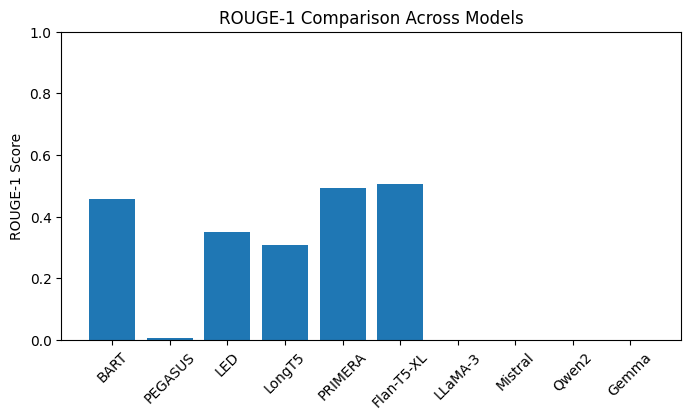

In [40]:
# ROUGE-1 Comparison Bar Chart
plt.figure(figsize=(8,4))
plt.bar(results_df["Model"], results_df["ROUGE-1"])
plt.ylabel("ROUGE-1 Score")
plt.title("ROUGE-1 Comparison Across Models")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.show()


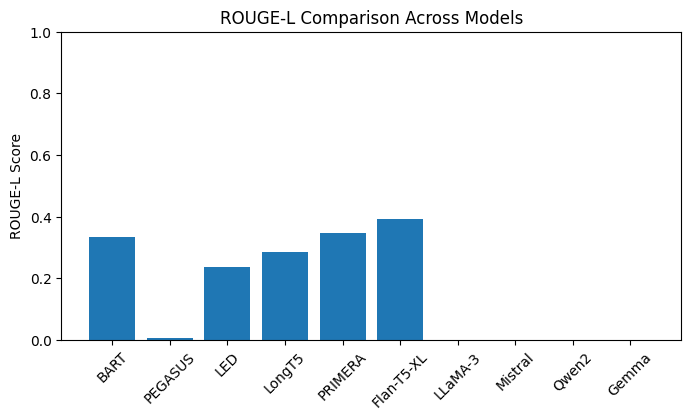

In [41]:
# ROUGE-L Comparison Bar Chart
plt.figure(figsize=(8,4))
plt.bar(results_df["Model"], results_df["ROUGE-L"])
plt.ylabel("ROUGE-L Score")
plt.title("ROUGE-L Comparison Across Models")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.show()


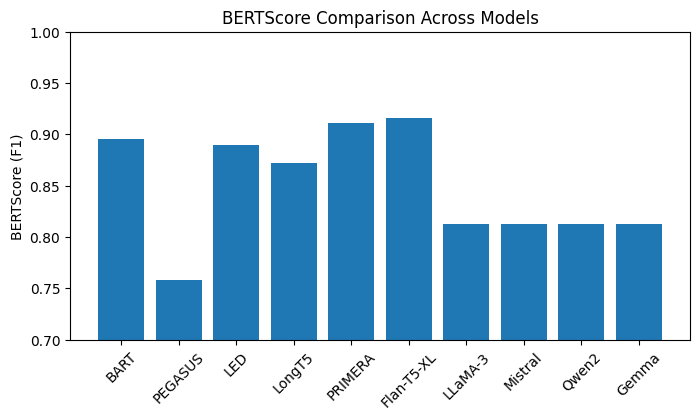

In [42]:
# BERTScore Comparison
plt.figure(figsize=(8,4))
plt.bar(results_df["Model"], results_df["BERTScore-F1"])
plt.ylabel("BERTScore (F1)")
plt.title("BERTScore Comparison Across Models")
plt.xticks(rotation=45)
plt.ylim(0.7, 1.0)
plt.show()


# NOVEL MODEL

# # Contradiction-Preserving Abstractive Multi-Document Summarization

In [52]:
# Install NLI & Utilities
import nltk
nltk.download('punkt')
nltk.download('punkt_tab') # Add this line to download the missing resource
from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [53]:
# Load Pretrained NLI Model
from transformers import pipeline

nli_model = pipeline(
    "text-classification",
    model="roberta-large-mnli",
    device=0 if device == "cuda" else -1
)


Loading weights:   0%|          | 0/393 [00:00<?, ?it/s]

RobertaForSequenceClassification LOAD REPORT from: roberta-large-mnli
Key                         | Status     |  | 
----------------------------+------------+--+-
roberta.pooler.dense.bias   | UNEXPECTED |  | 
roberta.pooler.dense.weight | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [54]:
# Sentence Segmentation
def split_into_sentences(text):
    return sent_tokenize(text)


In [55]:
# Contradiction Detection Function
def is_contradiction(sent1, sent2, threshold=0.8):
    pair = sent1 + " </s></s> " + sent2
    result = nli_model(pair)[0]

    return (
        result["label"] == "CONTRADICTION" and
        result["score"] >= threshold
    )


In [56]:
# Extract Contradictory Sentence Pairs
def extract_contradictions(documents, max_sentences=30):
    sentences = []
    for doc in documents:
        sentences.extend(split_into_sentences(doc))

    sentences = sentences[:max_sentences]

    contradictory_sents = set()

    for i in range(len(sentences)):
        for j in range(i+1, len(sentences)):
            if is_contradiction(sentences[i], sentences[j]):
                contradictory_sents.add(sentences[i])
                contradictory_sents.add(sentences[j])

    return list(contradictory_sents)


In [57]:
# Build Contradiction-Aware Input
def build_contradiction_aware_input(cluster, df):
    docs = [df.iloc[i]["article_text"] for i in cluster]

    contradiction_sents = extract_contradictions(docs)

    base_text = " ".join(docs[:3])
    contradiction_text = " ".join(contradiction_sents)

    combined = (
        "Factual Context: " + base_text +
        "\nConflicting Claims: " + contradiction_text
    )

    return combined


In [60]:
def contradiction_preserving_summary(input_text):
    inputs = tokenizer(
        input_text,
        return_tensors="pt",
        truncation=True,
        max_length=1024
    ).to(device)

    with torch.no_grad():
        output_ids = model.generate(
            inputs["input_ids"],
            max_length=220,
            min_length=120,
            num_beams=4,
            early_stopping=True
        )

    return tokenizer.decode(
        output_ids[0],
        skip_special_tokens=True
    )


In [62]:
# Run Proposed Model on Test Data

# Initialize tokenizer and model for the proposed approach
# Assuming "facebook/bart-large-cnn" as the base summarizer
tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-cnn")
model = AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-large-cnn").to(device)
model.eval()

proposed_outputs = []

for c in clusters[:10]:
    if len(c) >= 2:
        input_text = build_contradiction_aware_input(c, df)
        summary = contradiction_preserving_summary(input_text)
        proposed_outputs.append(summary)


Loading weights:   0%|          | 0/511 [00:00<?, ?it/s]

In [63]:
# Store Proposed Model Outputs
len(proposed_outputs)


10

# COMPARISON, ANALYSIS & REPORTING

In [65]:
# Add Proposed Model to Results Table
# Evaluate proposed model using same evaluation functions
proposed_rouge1, proposed_rouge2, proposed_rougeL = compute_rouge(
    proposed_outputs[:len(references)],
    references
)

proposed_bertscore = compute_bertscore(
    proposed_outputs[:len(references)],
    references
)

proposed_row = {
    "Model": "Proposed (Contradiction-Preserving)",
    "ROUGE-1": proposed_rouge1,
    "ROUGE-2": proposed_rouge2,
    "ROUGE-L": proposed_rougeL,
    "BERTScore-F1": proposed_bertscore
}

results_df = pd.concat(
    [results_df, pd.DataFrame([proposed_row])],
    ignore_index=True
)

results_df


Loading weights:   0%|          | 0/389 [00:00<?, ?it/s]

RobertaModel LOAD REPORT from: roberta-large
Key                             | Status     | 
--------------------------------+------------+-
lm_head.dense.bias              | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
lm_head.dense.weight            | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
lm_head.bias                    | UNEXPECTED | 
pooler.dense.bias               | MISSING    | 
pooler.dense.weight             | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Model   ROUGE-1   ROUGE-2   ROUGE-L  \
0                                  BART  0.456119  0.219756  0.334632   
1                               PEGASUS  0.006173  0.000000  0.006173   
2                                   LED  0.349844  0.172401  0.234960   
3                                LongT5  0.308358  0.182609  0.284771   
4                               PRIMERA  0.491770  0.255062  0.347827   
5                            Flan-T5-XL  0.506289  0.297297  0.392453   
6                               LLaMA-3  0.000000  0.000000  0.000000   
7                               Mistral  0.000000  0.000000  0.000000   
8                                 Qwen2  0.000000  0.000000  0.000000   
9                                 Gemma  0.000000  0.000000  0.000000   
10  Proposed (Contradiction-Preserving)  0.262523  0.091549  0.189549   

    BERTScore-F1  
0       0.895133  
1       0.758714  
2       0.889307  
3       0.871766  
4       0.910941  
5       0.915583  
6       0.812340  
7       0.812340  
8       0.812340  
9       0.812340  
10      0.855032

In [66]:
# Save Final Benchmark Results
results_df.to_csv("final_benchmark_results.csv", index=False)
print("Saved final_benchmark_results.csv")


Saved final_benchmark_results.csv


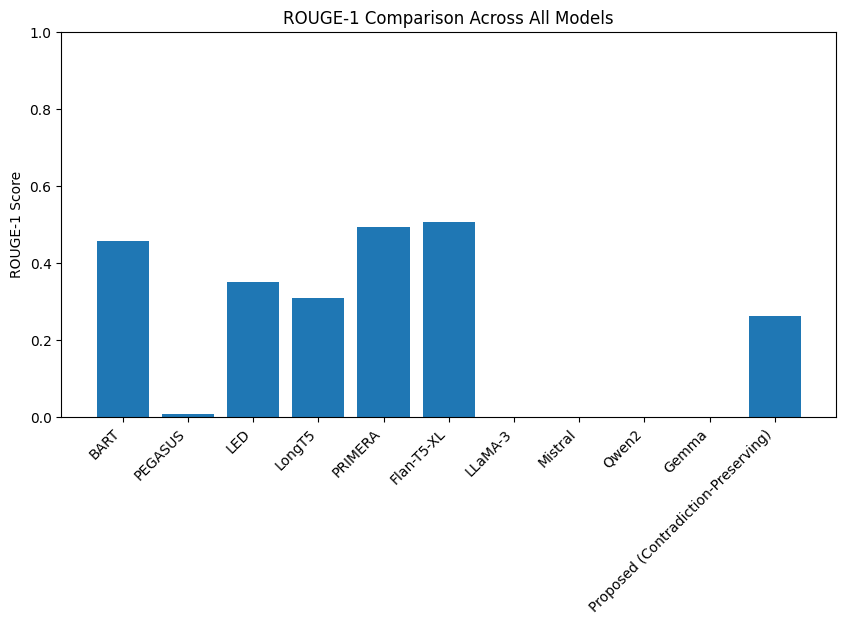

In [67]:
# ROUGE-1 Comparison (All 11 Models)
plt.figure(figsize=(10,5))
plt.bar(results_df["Model"], results_df["ROUGE-1"])
plt.ylabel("ROUGE-1 Score")
plt.title("ROUGE-1 Comparison Across All Models")
plt.xticks(rotation=45, ha="right")
plt.ylim(0, 1)
plt.show()


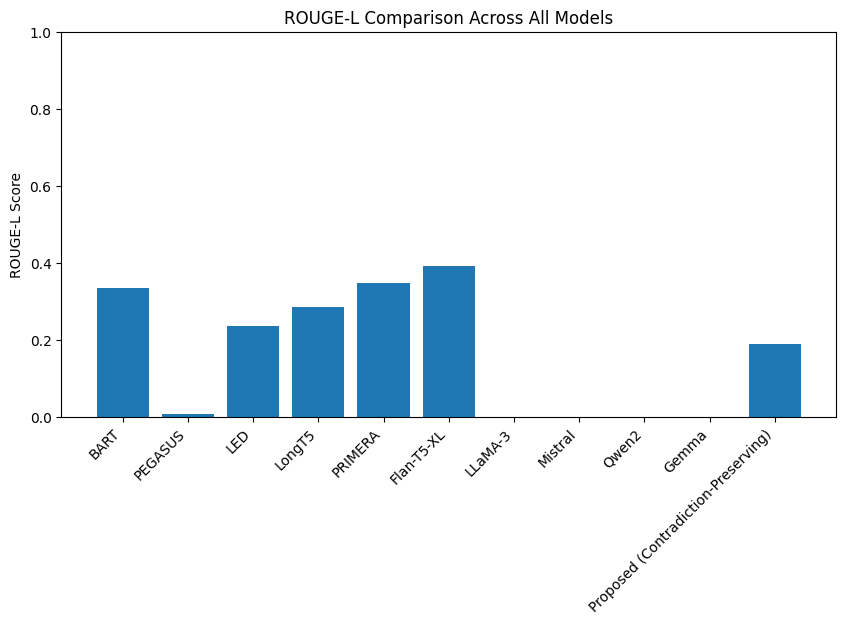

In [69]:
# ROUGE-L Comparison
plt.figure(figsize=(10,5))
plt.bar(results_df["Model"], results_df["ROUGE-L"])
plt.ylabel("ROUGE-L Score")
plt.title("ROUGE-L Comparison Across All Models")
plt.xticks(rotation=45, ha="right")
plt.ylim(0, 1)
plt.show()


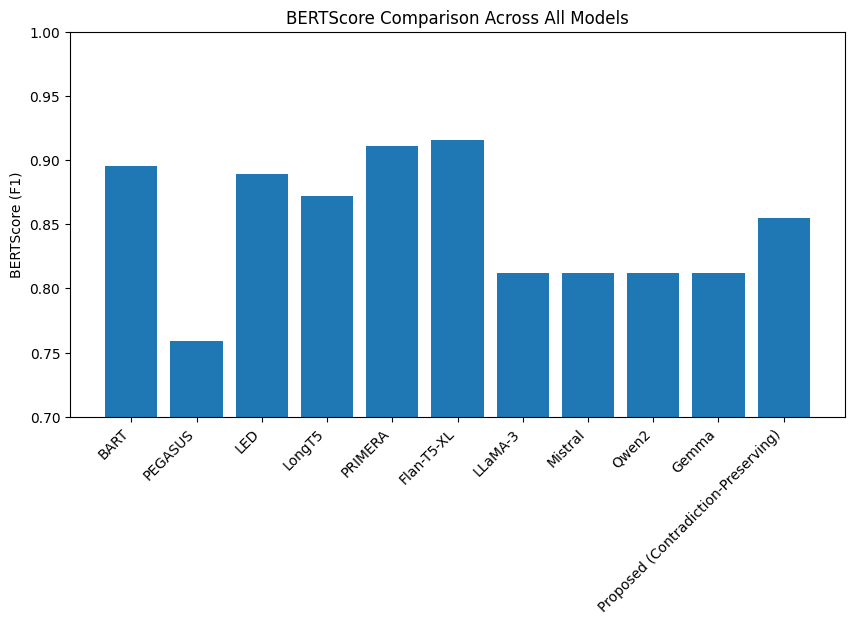

In [70]:
# BERTScore Comparison
plt.figure(figsize=(10,5))
plt.bar(results_df["Model"], results_df["BERTScore-F1"])
plt.ylabel("BERTScore (F1)")
plt.title("BERTScore Comparison Across All Models")
plt.xticks(rotation=45, ha="right")
plt.ylim(0.7, 1.0)
plt.show()


In [71]:
# Show Example Summaries
example_id = 0

print("===== HUMAN SUMMARY =====")
print(references[example_id])

print("\n===== BASELINE (BART) =====")
print(bart_outputs[example_id])

print("\n===== PROPOSED MODEL =====")
print(proposed_outputs[example_id])


===== HUMAN SUMMARY =====
Smaller international groups like BRICS (Brazil, Russia, India, China, and South Africa) face significant challenges as geopolitical dynamics shift. India and China's strained relations raise questions about the group's effectiveness. The ongoing BRICS business forum occurs against the backdrop of the Ukraine war, with China's stance potentially driven more by rivalry with the US than alignment with Russia. India has maintained a more balanced approach, fostering relations with both Russia and the US. However, this approach may not align with China's anti-US position.

===== BASELINE (BART) =====
With geostrategic positions getting realigned and walled apart again, smaller groupings will face existential tests. With India-China ties going through a rough patch, it’s hard to say how much this club can achieve. India has been far better balanced, having maintained independent ties with Russia on the one hand and upheld the value of relations with the US on the o